# Appointment - Train e Test del Modello

## Import delle librerie

Per prima cosa procediamo con l'importazione delle librerie necessarie al corretto funzionamento dell'addestramento.

In [119]:
!pip install --user -r requirements.txt

In [120]:
import pandas as pd
import numpy as np
import sklearn as sl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

## Caricamento dei dataset

Ora procediamo con il caricamento dei dataset creati nel primo file di questo progetto.

In [121]:
url_train = 'train.csv'
url_val = 'validation.csv'
url_test = 'test.csv'

In [122]:
train_data = pd.read_csv(url_train)
val_data = pd.read_csv(url_val)
test_data =pd.read_csv(url_test)

Verifichiamo che i dataset siano stati importati in modo corretto.

In [123]:
if train_data.empty or val_data.empty or test_data.empty:
    raise("I dataset non sono stati caricati correttamente.")

## Analisi del dataset di train

Ora analizziamo il dataset di train per avere maggiori informazioni per addestrare il modello

In [124]:
# Numero di righe e colonne nel dataset
print(f"Shape: {train_data.shape}")
print(f"Numero di righe (funghi): {train_data.shape[0]}")
print(f"Numero di colonne: {train_data.shape[1]}")

Shape: (56588, 14)
Numero di righe (funghi): 56588
Numero di colonne: 14


Osserviamo il tipo di ogni colonna.

In [125]:
test_data.dtypes

No-show            object
PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
dtype: object

Stampiamo i valori unici di ogni colonna.

In [126]:
# Stampa di tutti i valori unici di ogni colonna
for val in train_data:
    print(val, ': ', np.sort(train_data[val].unique()))
    print()

No-show :  ['No' 'Yes']

PatientId :  [4.37417565e+04 1.41724167e+05 5.62826100e+06 ... 9.99934989e+14
 9.99946537e+14 9.99981632e+14]

AppointmentID :  [5030230 5122866 5134220 ... 5790461 5790466 5790481]

Gender :  ['F' 'M']

ScheduledDay :  ['2015-11-10T07:13:56Z' '2015-12-03T08:17:28Z' '2015-12-07T10:42:42Z' ...
 '2016-06-08T19:32:25Z' '2016-06-08T19:33:23Z' '2016-06-08T19:58:52Z']

AppointmentDay :  ['2016-04-29T00:00:00Z' '2016-05-02T00:00:00Z' '2016-05-03T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-05-05T00:00:00Z' '2016-05-06T00:00:00Z'
 '2016-05-09T00:00:00Z' '2016-05-10T00:00:00Z' '2016-05-11T00:00:00Z'
 '2016-05-12T00:00:00Z' '2016-05-13T00:00:00Z' '2016-05-14T00:00:00Z'
 '2016-05-16T00:00:00Z' '2016-05-17T00:00:00Z' '2016-05-18T00:00:00Z'
 '2016-05-19T00:00:00Z' '2016-05-20T00:00:00Z' '2016-05-24T00:00:00Z'
 '2016-05-25T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-06-01T00:00:00Z' '2016-06-02T00:00:00Z' '2016-06-03T00:00:00Z'
 '2016-06-06T00:00:00Z' '2016-0

Stampa delle ricorrenze dei valori di ogni colonna.

In [127]:
# Stampa del conto dei valori presenti in ogni colonna
for val in train_data:
    print(train_data[val].value_counts())
    print()

No     45141
Yes    11447
Name: No-show, dtype: int64

9.963767e+10    49
2.584244e+11    39
8.221459e+14    38
8.923969e+13    37
3.353478e+13    37
                ..
5.378671e+13     1
2.956624e+13     1
8.716645e+14     1
1.659455e+12     1
1.488646e+11     1
Name: PatientId, Length: 39663, dtype: int64

5638143    1
5635242    1
5721276    1
5756054    1
5706935    1
          ..
5589416    1
5735962    1
5740056    1
5762583    1
5642243    1
Name: AppointmentID, Length: 56588, dtype: int64

F    36699
M    19889
Name: Gender, dtype: int64

2016-04-25T17:17:46Z    13
2016-05-06T07:09:53Z    11
2016-04-25T17:18:27Z    11
2016-04-25T17:17:23Z    10
2016-03-29T10:44:23Z     9
                        ..
2016-04-27T14:50:14Z     1
2016-05-12T09:10:39Z     1
2016-04-26T17:52:06Z     1
2016-05-03T07:55:37Z     1
2016-05-17T09:34:21Z     1
Name: ScheduledDay, Length: 54600, dtype: int64

2016-06-06T00:00:00Z    2354
2016-05-16T00:00:00Z    2328
2016-05-11T00:00:00Z    2315
2016-06-01T00:

## Rimozione delle righe con valori nulli

Procediamo ora con il cercare se ci sono righe nulle sia sul dataset di train che su quello di test. Tali righe saranno considerate non valide e dovranno, pertanto, essere rimosse dal dataset per evitare possibili errori durante l'addestramento. I simboli che in genere vengono utilizzati per intendere le righe nulle sono: "", " ", "?", "nan", "na", "NaN".

Come prima operazione ceschiamo di trovare i valori nulli nei vari dataset:

In [128]:
# Sostituisco ad ogni stringa vuola il valore 'NaN' nel dataset di train
train_data.replace("", np.nan, inplace=True)
train_data.replace(" ", np.nan, inplace=True)
train_data.replace("_", np.nan, inplace=True)
train_data.replace("-", np.nan, inplace=True)
train_data.replace("?", np.nan, inplace=True)
train_data.replace("nan", np.nan, inplace=True)
train_data.replace("na", np.nan, inplace=True)
train_data.replace("NaN", np.nan, inplace=True)

# Sostituisco ad ogni stringa vuola il valore 'NaN' nel dataset di train
val_data.replace("", np.nan, inplace=True)
val_data.replace(" ", np.nan, inplace=True)
val_data.replace("_", np.nan, inplace=True)
val_data.replace("-", np.nan, inplace=True)
val_data.replace("?", np.nan, inplace=True)
val_data.replace("nan", np.nan, inplace=True)
val_data.replace("na", np.nan, inplace=True)
val_data.replace("NaN", np.nan, inplace=True)

# Sostituisco ad ogni stringa vuola il valore 'NaN' nel dataset di test
test_data.replace("", np.nan, inplace=True)
test_data.replace(" ", np.nan, inplace=True)
test_data.replace("_", np.nan, inplace=True)
test_data.replace("-", np.nan, inplace=True)
test_data.replace("?", np.nan, inplace=True)
test_data.replace("nan", np.nan, inplace=True)
test_data.replace("na", np.nan, inplace=True)
test_data.replace("NaN", np.nan, inplace=True)

In [129]:
# Controllo dei dati non validi (NaN) nel dataset di train
train_data.isna().sum()

No-show           0
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
dtype: int64

In [130]:
# Controllo dei dati non validi (NaN) nel dataset di validation
train_data.isna().sum()

No-show           0
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
dtype: int64

In [131]:
# Controllo dei dati non validi (NaN) nel dataset di test
test_data.isna().sum()

No-show           0
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
dtype: int64

Adesso procediamo con la rimozione di tali valori:

In [132]:
# Procediamo con l'eliminazione dei dati non validi (NaN)
test_data.dropna(inplace=True)
val_data.dropna(inplace=True)
train_data.dropna(inplace=True)

Controlliamo che questi valori siano stati rimossi:

In [133]:
# Controllo dei dati non validi (NaN) nel dataset di train
train_data.isna().sum()

No-show           0
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
dtype: int64

In [134]:
# Controllo dei dati non validi (NaN) nel dataset di validation
train_data.isna().sum()

No-show           0
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
dtype: int64

In [135]:
# Controllo dei dati non validi (NaN) nel dataset di test
test_data.isna().sum()

No-show           0
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
dtype: int64

## Statistiche sul dataset

Vediamo ora un po' di statistiche dei valori contenuti nel dataset.

In [136]:
# Statistiche del dataset
train_data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,5.658800e+04,5.658800e+04,56588.000000,56588.000000,56588.000000,56588.000000,56588.000000,56588.000000,56588.000000
mean,1.484267e+14,5.675246e+06,37.127783,0.100198,0.198699,0.072719,0.030855,0.022125,0.321464
std,2.572179e+14,7.145009e+04,23.103861,0.300266,0.399025,0.259676,0.172925,0.163154,0.467043
min,4.374176e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.148654e+12,5.640432e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.190606e+13,5.680798e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.475128e+13,5.725426e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790481e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Osserviamo le quantità di persone che si sono presentate alla visita.

In [137]:
# Numero delle persone che non si sono presentate alla visita (No-show)
# No: si sono presentati
# Yes: non si sono presentati
train_data['No-show'].value_counts()

No     45141
Yes    11447
Name: No-show, dtype: int64

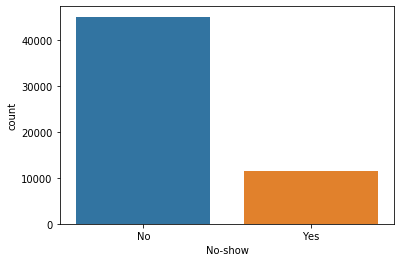

In [138]:
# Diagramma che confronta le persone che hanno lasciato la compagnia telefonica
sns.countplot(train_data['No-show'])

Ora invece mettiamo in relazione le features del dataset con la quantità di gente che non si è presentata alla visita prenotata.

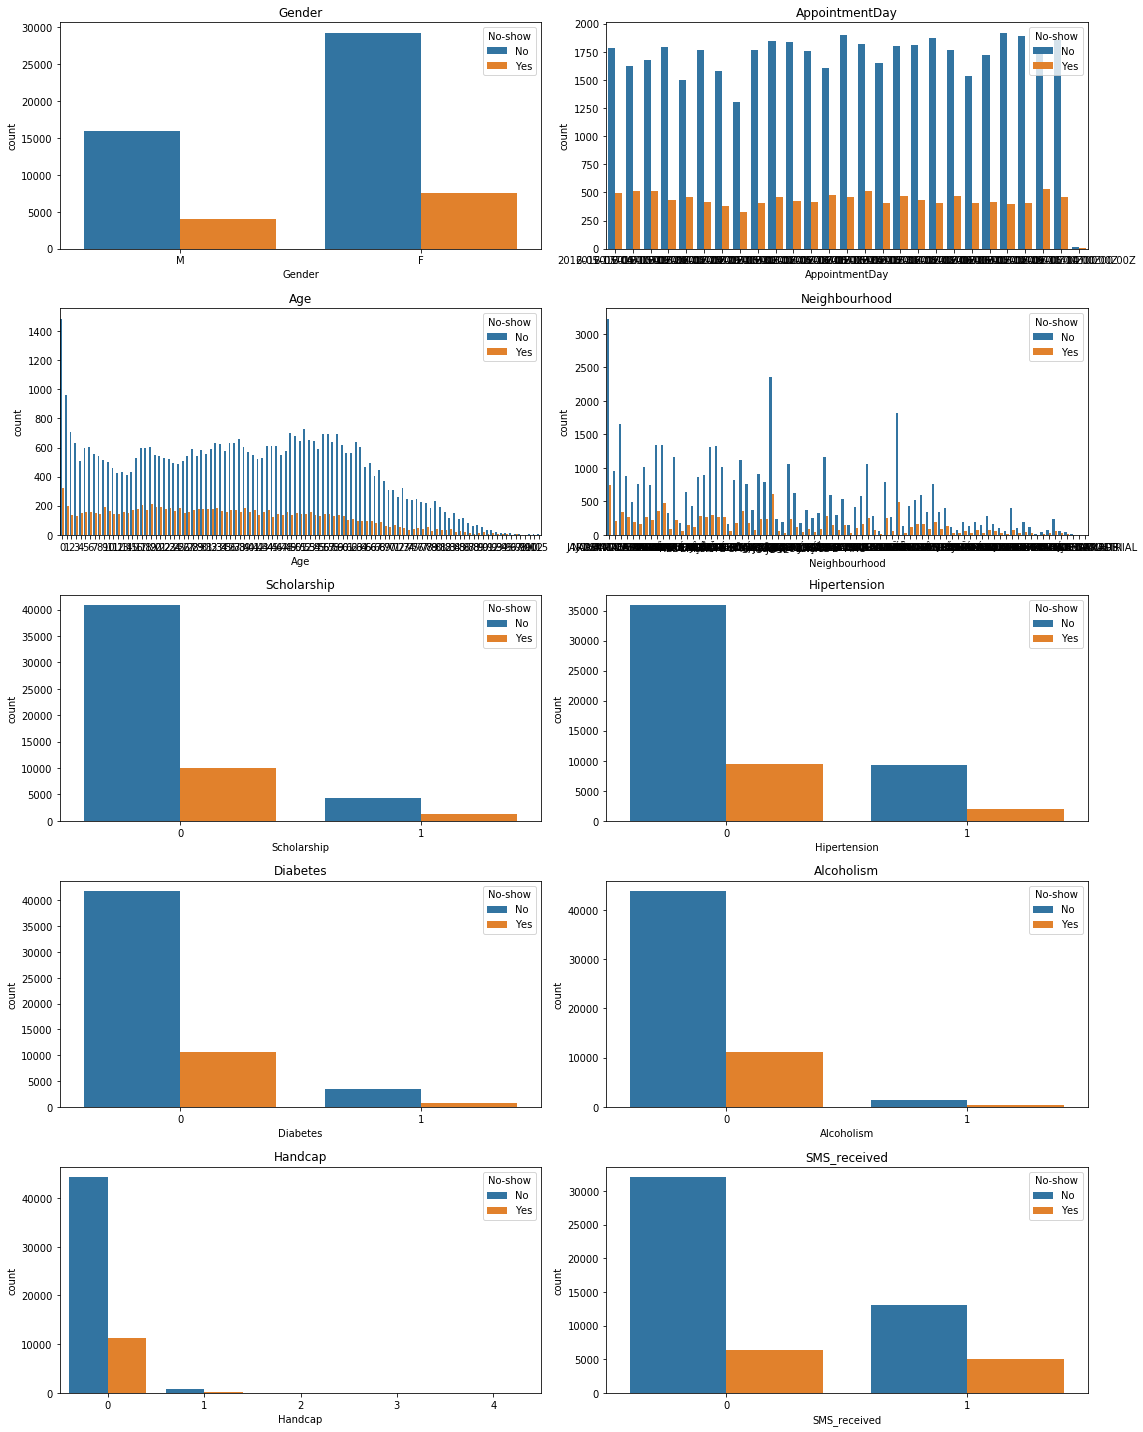

In [139]:
# Alcuni grafici che mettono in relazione le features
# del dataset con le persone che non si sono presentati alla visita

cols = ['Gender', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship',
       'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']

n_rows = 5
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*4))
i=0
for r in range(n_rows):
    for c in range(n_cols):
        ax = axs[r][c]
        sns.countplot(train_data[cols[i]], hue=train_data['No-show'], ax=ax)
        ax.set_title(cols[i])
        ax.legend(title='No-show', loc='upper right')
        i+=1
    
plt.tight_layout()

## Modifica di alcune colonne

Una delle prime cose che abbiamo potuto osservare fino ad ora è come le date vengano gestite come degli oggetti. Invece di considerare ScheduledDay e AppointmentDay come due date separate possiamo aggregarle prendendone la differenza. Aggiungiamo, inoltre, anche una nuova colonna che contiene il giorno della settimana in cui è previsto l'appuntamento.

In [140]:
# Funzione che restituisce una lista contenete la differenza
# tra le date di appuntamento e le date di quando l'appuntamento
# è stato preso.
def make_timedelta(data):
    app_day = pd.to_datetime(data['AppointmentDay']).dt.date
    sch_day = pd.to_datetime(data['ScheduledDay']).dt.date

    time_delta = []
    for elem_app, elem_shc in zip (app_day, sch_day):
        time_delta.append((elem_app-elem_shc).days)
    
    return time_delta

In [141]:

# Funzione che restituisce una lista contenente i giorni della
# settimana in cui deve avvenire l'appuntamento
def get_weekday(data):
    app_day = pd.to_datetime(data['AppointmentDay']).dt.date

    weekdays = []
    for elem_app in  app_day:
        weekdays.append((elem_app.weekday()))
    
    return weekdays

In [142]:
# Creazione di una colonna che contiene la differenza tra 'AppointmentDay'
# e 'ScheduledDay' nel file di train. Le stesse colonne verranno anche eliminate
# dal dataset.
train_data['Time_delta'] = make_timedelta(train_data)
train_data['Week_day'] = get_weekday(train_data)

# Creazione di una colonna che contiene la differenza tra 'AppointmentDay'
# e 'ScheduledDay' nel file di test. Le stesse colonne verranno anche eliminate
# dal dataset.
test_data['Time_delta'] = make_timedelta(test_data)
test_data['Week_day'] = get_weekday(test_data)

In [143]:
train_data.head(10)

,No-show,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Time_delta,Week_day
0,No,9.333939e+14,5696967,M,2016-05-13T14:43:45Z,2016-05-17T00:00:00Z,10,JARDIM CAMBURI,0,0,0,0,0,0,4,1
1,No,6.383944e+12,5656790,F,2016-05-04T08:31:35Z,2016-05-04T00:00:00Z,14,NOVA PALESTINA,0,0,0,0,0,0,0,2
2,No,1.333989e+12,5675741,M,2016-05-09T14:16:29Z,2016-05-10T00:00:00Z,44,JARDIM CAMBURI,0,0,0,0,0,0,1,1
3,No,8.928723e+13,5646002,F,2016-05-02T10:42:21Z,2016-05-19T00:00:00Z,65,JARDIM DA PENHA,0,1,0,0,0,0,17,3
4,No,3.149150e+14,5700768,F,2016-05-16T09:45:46Z,2016-05-20T00:00:00Z,2,ANDORINHAS,0,0,0,0,0,0,4,4
5,Yes,7.489962e+12,5620718,M,2016-04-26T09:21:13Z,2016-05-19T00:00:00Z,57,SANTOS DUMONT,0,1,0,0,0,0,23,3
6,No,6.354497e+12,5766473,F,2016-06-02T15:11:19Z,2016-06-02T00:00:00Z,77,JARDIM CAMBURI,0,0,0,0,0,0,0,3
7,Yes,6.966595e+13,5622376,M,2016-04-26T12:00:07Z,2016-05-25T00:00:00Z,7,ILHA DE SANTA MARIA,0,0,0,0,0,0,29,2
8,No,7.879474e+13,5589693,F,2016-04-15T12:42:49Z,2016-04-29T00:00:00Z,33,CARATOÍRA,1,0,0,0,0,1,14,4
9,No,9.694418e+13,5644263,F,2016-05-02T08:27:31Z,2016-05-03T00:00:00Z,66,MARUÍPE,1,0,0,0,0,0,1,1


Come per prima creiamo dei grafici per mettere in relazione queste due nuove colonne con le persone che non si sono presentate alle visite che avevano prenotato.

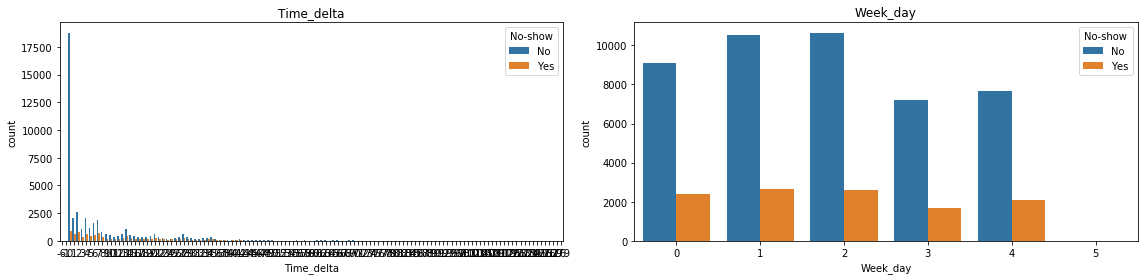

In [144]:
# Stampa dei grafici che mettono in relazione le colonne appena
# create con le persone che non si sono presentati alla visita

cols = ['Time_delta', 'Week_day']

n_rows = 1
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*4))
i=0
for r in range(n_rows):
    for c in range(n_cols):
        ax = axs[c]
        sns.countplot(train_data[cols[i]], hue=train_data['No-show'], ax=ax)
        ax.set_title(cols[i])
        ax.legend(title='No-show', loc='upper right')
        i+=1
    
plt.tight_layout()

Si osserva come minore sia la distanza tra il giorno dell'appuntamento e il giorno della prenotazione, maggiore è la possibilità che una persona si presenti.

## Divisione del dataset

Ora iniziamo a prepararci per l'addestramento del modello. Per prima cosa, dopo aver deciso le features su cui addestrare la rete, procediamo con la divisione del dataset in due parti: y che contiene solo la colonna delle label e X che conterrà tutto il resto.

In [145]:
# Scegliamo la colonna su cui si desidera addestrare la rete, ovvero
# la nostra 'label'
label = 'No-show'

# Scegliamo le colonne su cui NON voglimo addestrare il modello
not_features = ['AppointmentID', 'Gender', 'AppointmentDay', 'ScheduledDay']

In [146]:
# Dividiamo il train-set e il test-set in due parti così da poter addestrare la rete:
# y che contiene solo la colonna label 'No-show' che consiste nella soluzione al problema
# X che contiene tutte le altre colonne specificate in 'features'.
y_train = train_data.pop(label)
X_train = train_data.drop(not_features, axis=1)

y_test = test_data.pop(label)
X_test = test_data.drop(not_features, axis=1)

## Modello

La creazione del modello si divide in due fasi, una prima che si occuperà della fase di preprocessing dei dati del dataset e una seconda in cui verrà dichiarato il classificatore. Questi due verranno poi inseriti in una Pipeline.

### Preprocessng dei dati

Per prima cosa eseguiamo l'encoder sulla colonna label y.

In [147]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Poi procediamo con la creazione di una Pipelin che si occuperà di processare i dati in ingresso del dataset X. Questa seconda parte è divisa in due Pipeline, una che si occupa di processare i dati numerici e una seconda che ineve farà l'encoder dei dati categorici.

In [148]:
# Definiamo le colonne che sono in forma numerica
numeric_features = list(X_train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']))
not_numeric_features = list(X_train.columns[X_train.dtypes=='object'])

In [149]:
# Definiamo una Pipeline per la codifica dei valori Numerici
numeric_transformer = Pipeline(
    steps=[('simple_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [150]:
# Definiamo una Pipeline per la codifica dei valori NON Numerici
not_numeric_transformer = Pipeline(
    steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
           ('categorical', OrdinalEncoder())])

Infine assembliamo le Pipeline fino ad ora create in un trasformer per colonne.

In [151]:
preprocessor = ColumnTransformer(
    transformers=[('numeric_transformer', numeric_transformer, numeric_features),
                  ('not_numeric_transformer', not_numeric_transformer, not_numeric_features)])

### Dichiarazione del modello

Ora è il momento di includere nella Pipeline il classificatore che si occuperà dell'addestramento e della predizione dei dati.

In [152]:
# Creazione del modetto tramite una Pipeline. In essa sono sono
# spiegati l'ordine per il preprocessing e per il classificatore.
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

Il classificatore che è stato utilizzato prende il nome di RandomForestClassifier. Questo algoritmo addestra un certo numero di alberi classificatori su delle piccole porzioni del dataset e ne calcola una media dei risultati per migliorare l'accuracy di predizione dei dati che seguiranno.

In [153]:
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PatientId', 'Age',
                                                   'Scholarship',
                                                   'Hipertension', 'Diabetes',
                                                   'Alcoholism', 'Handcap',
                                                   'SMS_received', 'Time_delta',
                                                   'Week_day']),
                                                 ('not_numeric_transformer',
                           

## Addestramento

Una volta creato il modello si può procedere con l'addestramento sui dati di train.

In [154]:
# Addestramento del modello
model = model.fit(X_train, y_train)

# Calcolo dello score di addestramento del modello
score = model.score(X_train, y_train)

print(f"Training score: {score:.4%}")

Training score: 99.4380%


## Valutazione

Ora eseguiamo la valutazione del modello tramite la predizione dei valori di test.

In [158]:
# Predizione dei dati di test
prediction = model.predict(X_test)

# Calcolo dell'accuracy
acc = accuracy_score(y_test, prediction)

print(f"Prediction Accuracy: {acc:.4%}")

Prediction Accuracy: 79.3271%


## Confusion Matrix

Stampiamo ora una confusion matrix con i valori trovati.

In [159]:
# Creazione di una confusion matrix
conf_matr = confusion_matrix(y_test, prediction, normalize=None)

In [160]:
# Stampa della confusion matrix
print(conf_matr)

[[13551   629]
 [ 3027   478]]


[[13551   629]
 [ 3027   478]]


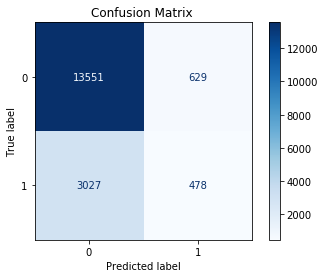

In [161]:
disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix ")



print(disp.confusion_matrix)
plt.show()

## Concusioni

Con i dati che sono stati forniti non è possibile addestrare un modello che predica in maniera corretta i valori di test. Come è possibile osservare attraverso la Confusion Matrix il modello addestrato predice per il 93,75% il valore 0 lascando intuire che il modello non abbia realmente imparato a predirre attraverso le features.

Il modello ottenuto non può essere ritenuto accettabile ma questo è il massimo che si può ottenere attraverso questo dataset non bilanciato.